# SEPTA Subway Zoning Analysis and Ridership Model
## Summary



## Data Wrangling
Although primarily based in Philadelphia County, SEPTA subway stops do venture into or next to neighboring Delaware County. As such, it is necessary to gather zoning data from both counties. Fortunately, they both have easily downloadable zoning maps, unfortunately, in Delaware county zoning codes are determined by individual jurisdictions (townships, boroughs etc.). The data is messy and requires looking at each individual jurisdictions' zoning code to determine the general category of zoning. Philadelphia has a unified zoning code, so it is easier to assimilate each code into a category. 

In [2]:
import os
from pygris import block_groups
from pygris.data import get_lodes
from pygris.data import get_census
from shapely.geometry import Point
from census import Census
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor
import statsmodels.api as sm

# driver support for kml files is needed to load in Delware County Zoning data
# fiona.drvsupport.supported_drivers['libkml'] = 'rw' 
# fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'

### Data Sources:  
Ridership Data: [SEPTA's FY 2023 Route Statistics](https://planning.septa.org/wp-content/uploads/2023/09/2023-ROUTE-STATS-WEB-1.pdf)  
Station Data: [SEPTA Open Data Portal](https://data-septa.opendata.arcgis.com/datasets/1e7754ca5f7d47e480a628e282466428_0/explore?location=40.009335%2C-75.214863%2C11.65)  
Philadelphia Zoning: [City of Philadelphia OpenMaps Dashboard](https://openmaps.phila.gov/)  
Delware County Zoning: [Delaware County Open Data hub](https://delaware-county-pennsylvania-dcpd.hub.arcgis.com/datasets/67e0df30839247f9866177d472cc6d4d_0/explore)  

In [3]:
import warnings
# ignore future warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load in the data
mfl_ridership = pd.read_csv('MFL_Ridership.csv')
bsl_ridership = pd.read_csv('BSL_Ridership.csv')
stations = gpd.read_file('Metro_Stations')
philly_zoning = gpd.read_file('Zoning_BaseDistricts')
delco_zoning = gpd.read_file('Delaware_County_Zoning.kml')
boulevard_extension = gpd.read_file('Boulevard_Extension')
# Convert boulevard_extension to a GeoDataFrame
boulevard_extension = gpd.GeoDataFrame(boulevard_extension, geometry='geometry')




# Data Cleaning
There are a lot of collumns in the philly_zoning that are not needed for this analysis, so they will be removed. The only data necceesary is the geometry, and the zoning code. There are also some spelling issues that should be fixed to ensure compatibility with delco_zoning. 

In [4]:
philly_zoning.head()

,OBJECTID,CODE,CITYCOR,LONG_CODE,ZONINGGROU,PENDING,PENDINGBIL,PENDINGB_1,SUNSET_DAT,SUNSETBILL,SUNSETBI_1,Shape__Are,Shape__Len,geometry
0,1,SPPOA,0.0,SP-PO-A,Special Purpose,No,N/A,N/A,NaT,N/A,N/A,3371.062500,257.688146,"POLYGON ((-75.21633 39.95295, -75.21673 39.953..."
1,2,CMX2,0.0,CMX-2,Commercial/Commercial Mixed-Use,No,N/A,N/A,NaT,N/A,N/A,159.539062,63.896038,"POLYGON ((-75.14301 39.99895, -75.14299 39.998..."
2,3,RSA5,0.0,RSA-5,Residential/Residential Mixed-Use,No,N/A,N/A,NaT,N/A,N/A,1721.378906,182.886474,"POLYGON ((-75.0613 40.01405, -75.06135 40.0140..."
3,4,CMX1,0.0,CMX-1,Commercial/Commercial Mixed-Use,No,N/A,N/A,NaT,N/A,N/A,137.417969,55.579486,"POLYGON ((-75.10094 39.98413, -75.10097 39.984..."
4,5,CMX2,0.0,CMX-2,Commercial/Commercial Mixed-Use,No,N/A,N/A,NaT,N/A,N/A,524.609375,92.058804,"POLYGON ((-75.12863 40.01916, -75.12854 40.019..."


In [5]:
philly_zoning = philly_zoning[['geometry', 'LONG_CODE', 'Shape__Are', 'Shape__Len']]
philly_zoning = philly_zoning.rename(columns = { 'Shape__Are': 'Area', 'Shape__Len': 'Perimeter'})

Now we need to do the same with delco_zoning. 

In [6]:
delco_zoning.head()

,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,...,QA_Municipality,Group_Category,Source,created_user,created_date,last_edited_user,last_edited_date,Shape__Area,Shape__Length,geometry
0,None,None,NaT,NaT,NaT,None,-1.0,0.0,-1,NaN,...,No,R-3,Zoning Districts shown are taken from Darby Bo...,None,None,None,None,8.372311e+06,44018.962780,"MULTIPOLYGON (((-75.26143 39.92126, -75.26112 ..."
1,None,None,NaT,NaT,NaT,None,-1.0,0.0,-1,NaN,...,No,R-1,Zoning Districts shown are taken from Darby Bo...,None,None,None,None,2.431261e+05,2558.622252,"POLYGON ((-75.26782 39.92613, -75.26776 39.926..."
2,None,None,NaT,NaT,NaT,None,-1.0,0.0,-1,NaN,...,No,I - Institutional District,Zoning Districts shown are taken from Darby Bo...,None,None,None,None,4.936619e+06,28391.193442,"MULTIPOLYGON (((-75.25795 39.92439, -75.25777 ..."
3,None,None,NaT,NaT,NaT,None,-1.0,0.0,-1,NaN,...,No,HC - Highway Commercial District,Zoning Districts shown are taken from Darby Bo...,None,None,None,None,2.713381e+06,22258.777867,"MULTIPOLYGON (((-75.27083 39.92057, -75.27066 ..."
4,None,None,NaT,NaT,NaT,None,-1.0,0.0,-1,NaN,...,No,R-2,Zoning Districts shown are taken from Darby Bo...,None,None,None,None,4.110935e+06,23186.859478,"MULTIPOLYGON (((-75.25453 39.9169, -75.25445 3..."


In [7]:
delco_zoning = delco_zoning[['geometry', 'LABEL', 'Shape__Area', 'Shape__Length', 'MUNI_NAME']]
delco_zoning = delco_zoning.rename(columns = { 'Shape__Area': 'Area', 'Shape__Length': 'Perimeter'})

In [8]:
# Remove commas from bsl_ridership and mfl_ridership and convert to float
bsl_ridership['AVERAGE WEEKDAY'] = bsl_ridership['AVERAGE WEEKDAY'].replace({',': ''}, regex=True).astype(float)
mfl_ridership['AVERAGE WEEKDAY'] = mfl_ridership['AVERAGE WEEKDAY'].replace({',': ''}, regex=True).astype(float)


Now it's time to add ridership data to our stations

In [9]:
# Add the name of the line to stations that have duplicate names
stations['Station'] = np.where(stations['Station'].duplicated(), stations['Station'] + ' ' + stations['Route'], stations['Station'])
# Remove the Norristown Highspeed Line from the stations data provided by SEPTA
stations = stations[~(stations['Route'] == 'Norristown Highspeed Line')] 

# Combine ridership data for both lines
station_ridership = pd.concat([bsl_ridership, mfl_ridership])
# Reset the index of station_ridership
station_ridership = station_ridership.reset_index(drop=True)

# Rename the 'STATION' column to 'Station'
station_ridership.rename(columns = {'STATION': 'Station'}, inplace=True)

# Merge station_ridership with stations
stations = pd.merge(stations, station_ridership, on='Station', how='left')


Remove unnecessary columns from boulevard_extension, and the two stations that are outside of Philadelphia County.

In [10]:
boulevard_extension.drop(columns = ['OBJECTID', 'FID'], inplace=True)
boulevard_extension = boulevard_extension.drop([10, 11])

### Zoning Categories
For Philadelphia's zoning, I decided to categorize each zoning code into a general and specific category based on the type of construction permitted and its density. I then mapped these categories to the zoning data using a dictionary. 

In [11]:
# Dictionary to map the zoning categories to the zoning codes
philly_zoning_categories = {
    "RSD-1": ("Residential Zoning Districts", "Single-Family Detached"),
    "RSD-2": ("Residential Zoning Districts", "Single-Family Detached"),
    "RSD-3": ("Residential Zoning Districts", "Single-Family Detached"),
    "RSA-1": ("Residential Zoning Districts", "Single-Family Attached"),
    "RSA-2": ("Residential Zoning Districts", "Single-Family Attached"),
    "RSA-3": ("Residential Zoning Districts", "Single-Family Attached"),
    "RSA-4": ("Residential Zoning Districts", "Single-Family Attached"),
    "RSA-5": ("Residential Zoning Districts", "Single-Family Attached"),
    "RSA-6": ("Residential Zoning Districts", "Single-Family Attached"),
    "RM-1": ("Residential Zoning Districts", "Multi-Family Residential"),
    "RM-2": ("Residential Zoning Districts", "Multi-Family Residential"),
    "RM-3": ("Residential Zoning Districts", "Multi-Family Residential"),
    "RM-4": ("Residential Zoning Districts", "Multi-Family Residential"),
    "RMX-1": ("Residential Zoning Districts", "Mixed-Use Residential"),
    "RMX-2": ("Residential Zoning Districts", "Mixed-Use Residential"),
    "RMX-3": ("Residential Zoning Districts", "Mixed-Use Residential"),
    "RTA-1": ("Residential Zoning Districts", "Two-Family Residential"),
    "RTA-2": ("Residential Zoning Districts", "Two-Family Residential"),
    "CMX-1": ("Commercial Zoning Districts", "Neighborhood Commercial"),
    "CMX-2": ("Commercial Zoning Districts", "Neighborhood Commercial"),
    "CMX-2.5": ("Commercial Zoning Districts", "Neighborhood Commercial"),
    "CMX-3": ("Commercial Zoning Districts", "Community and Regional Commercial"),
    "CMX-4": ("Commercial Zoning Districts", "Community and Regional Commercial"),
    "CMX-5": ("Commercial Zoning Districts", "Center City Commercial"),
    "CA-1": ("Commercial Zoning Districts", "Auto-Oriented Commercial"),
    "CA-2": ("Commercial Zoning Districts", "Auto-Oriented Commercial"),
    "I-1": ("Industrial Zoning Districts", "Light and Medium Industrial"),
    "I-2": ("Industrial Zoning Districts", "Light and Medium Industrial"),
    "I-3": ("Industrial Zoning Districts", "Heavy Industrial"),
    "I-P": ("Industrial Zoning Districts", "Port Industrial"),
    "IRMX": ("Industrial Zoning Districts", "Industrial Mixed-Use"),
    "ICMX": ("Industrial Zoning Districts", "Industrial Mixed-Use"),
    "SP-INS": ("Special Purpose Zoning Districts", "Institutional"),
    "SP-CIV": ("Special Purpose Zoning Districts", "Civic, Educational and Medical"),
    "SP-ENT": ("Special Purpose Zoning Districts", "Entertainment"),
    "SP-PO-A": ("Special Purpose Zoning Districts", "Parks and Open Spaces"),
    "SP-PO-P": ("Special Purpose Zoning Districts", "Parks and Open Spaces"),
    "SP-STA": ("Special Purpose Zoning Districts", "Sports Stadium"),
    "SP-AIR": ("Special Purpose Zoning Districts", "Airport")
}
# Map the zoning categories to the zoning codes
philly_zoning['LONG_CODE'] = philly_zoning['LONG_CODE'].astype(str)
philly_zoning['General_Category'] = philly_zoning['LONG_CODE'].map(philly_zoning_categories).str[0]
philly_zoning['Specific_Category'] = philly_zoning['LONG_CODE'].map(philly_zoning_categories).str[1]
philly_zoning.head()

,geometry,LONG_CODE,Area,Perimeter,General_Category,Specific_Category
0,"POLYGON ((-75.21633 39.95295, -75.21673 39.953...",SP-PO-A,3371.062500,257.688146,Special Purpose Zoning Districts,Parks and Open Spaces
1,"POLYGON ((-75.14301 39.99895, -75.14299 39.998...",CMX-2,159.539062,63.896038,Commercial Zoning Districts,Neighborhood Commercial
2,"POLYGON ((-75.0613 40.01405, -75.06135 40.0140...",RSA-5,1721.378906,182.886474,Residential Zoning Districts,Single-Family Attached
3,"POLYGON ((-75.10094 39.98413, -75.10097 39.984...",CMX-1,137.417969,55.579486,Commercial Zoning Districts,Neighborhood Commercial
4,"POLYGON ((-75.12863 40.01916, -75.12854 40.019...",CMX-2,524.609375,92.058804,Commercial Zoning Districts,Neighborhood Commercial


In [12]:
# Remove the Norristown Highspeed Line from the stations data provided by SEPTA
stations = stations[~(stations['Route'] == 'Norristown Highspeed Line')]  

# Convert the coordinate reference system of the data to EPSG:3347 (meter-based projection)
boulevard_extension = boulevard_extension.to_crs("EPSG:3347")  
stations = stations.to_crs("EPSG:3347")  
delco_zoning = delco_zoning.to_crs("EPSG:3347")  
philly_zoning = philly_zoning.to_crs("EPSG:3347")  


In [13]:
# Add the name of the line to stations that have duplicate names
stations['Station'] = np.where(stations['Station'].duplicated(), stations['Station'] + ' ' + stations['Route'], stations['Station'])
stations.head()

,FID,Route,Station,Latitude,Longitude,geometry,AVERAGE WEEKDAY,SCHEDULED TRIPS,STATION ECONOMIC PERFORMANCE
0,1,Broad Street Line,NRG,39.905434,-75.173936,POINT (7675150.622 591876.943),1541.0,270,5.71
1,2,Broad Street Line,Oregon,39.916815,-75.171339,POINT (7675032.079 593212.907),4045.0,270,14.98
2,3,Broad Street Line,Snyder,39.924386,-75.169681,POINT (7674947.161 594099.973),5500.0,270,20.37
3,4,Broad Street Line,Tasker-Morris,39.929848,-75.168501,POINT (7674884.506 594739.534),4505.0,270,16.69
4,5,Broad Street Line,Ellsworth-Federal,39.936194,-75.167129,POINT (7674811.662 595482.599),3715.0,270,13.76


### Delaware County Zoning
Assigning categories to zoning parcels in Delaware County will not be as straightforward as it was for Philadelphia. As previously mentioned, each low level jurisdiction determines its zoning code, so its necessary to look into their individual zoning codes. However, we can make this process much easier only categorizing the zoning codes of jurisdictions near subway stations. To do this, I created a buffer of 800 meters (1/2 mile), about a 15 minute walk, around each station. I then overlayed that buffer the zoning data for Delaware County and created a new geodataframe from what intersected. From there I can find any unique values in the 'MUNI_NAME' column, those will be the jurisdictions I need zoning data from.

In [14]:
stations['Station'] = np.where(stations['Station'].duplicated(), stations['Station'] + ' ' + stations['Route'], stations['Station'])

stations_buffered = stations.copy()
stations_buffered['geometry'] = stations.geometry.buffer(800)  # Buffer by 800 meters

stations.buffer
stations_buffered.head()

zoning_near_delco = gpd.overlay(delco_zoning, stations_buffered, how='intersection')

print(zoning_near_delco['MUNI_NAME'].unique())

['Millbourne Borough' 'Upper Darby Township']


There it is! So now I just need to find zoning information of Milbourne Borough and Upper Darby Township and build a dictionary to map to the data.

In [15]:
# Dictionary for Upper Darby Township
upper_darby_zoning_categories = {
    "R-3": ("Residential Zoning Districts", "Single-Family Detached"),
    "R-4": ("Residential Zoning Districts", "Single-Family Detached"),
    "C-1": ("Commercial Zoning Districts", "Neighborhood Commercial"),
    "C-3": ("Commercial Zoning Districts", "Community and Regional Commercial"),
    "C-4": ("Commercial Zoning Districts", "Community and Regional Commercial"),
    "REC": ("Special Purpose Zoning Districts", "Parks and Open Spaces"),
}
# Dictionary for Milbourne Borough
milbourne_zoning_categories = {
    "R-1": ("Residential Zoning Districts", "Single-Family Detached"),
    "R-2": ("Residential Zoning Districts", "Single-Family Attached"),
    "NBD": ("Commercial Zoning Districts", "Neighborhood Commercial"),
    "GBD": ("Commercial Zoning Districts", "Auto-Oriented Commercial"),
    "PCD": ("Commercial Zoning Districts", "Community and Regional Commercial"),
    "C-INS": ("Commercial Zoning Districts", "Auto-Oriented Commercial"),
}

# There are no overlapping zoning codes between the two municipalities so I can combine them into one dictionary
delco_zoning_categories = upper_darby_zoning_categories | milbourne_zoning_categories
delco_zoning_categories
delco_zoning = delco_zoning[(delco_zoning['MUNI_NAME'] == 'Millbourne Borough') | (delco_zoning['MUNI_NAME'] == 'Upper Darby Township')]
delco_zoning['LABEL'] = delco_zoning['LABEL'].astype(str)
delco_zoning['General_Category'] = delco_zoning['LABEL'].map(delco_zoning_categories).str[0]
delco_zoning['Specific_Category'] = delco_zoning['LABEL'].map(delco_zoning_categories).str[1]
delco_zoning.head()

,geometry,LABEL,Area,Perimeter,MUNI_NAME,General_Category,Specific_Category
44,"POLYGON ((7666678.563 596782.397, 7666677.202 ...",PCD,831740.841046,6690.874739,Millbourne Borough,Commercial Zoning Districts,Community and Regional Commercial
157,"POLYGON ((7666288.514 596420.961, 7666298.824 ...",R-2,375919.515932,2871.064755,Millbourne Borough,Residential Zoning Districts,Single-Family Attached
158,"POLYGON ((7666302.13 596390.609, 7666274.391 5...",GBD,242147.625784,2756.399406,Millbourne Borough,Commercial Zoning Districts,Auto-Oriented Commercial
159,"POLYGON ((7666864.083 596634.428, 7666851.899 ...",R-1,287672.464051,2536.802704,Millbourne Borough,Residential Zoning Districts,Single-Family Detached
160,"POLYGON ((7666614.147 596519.517, 7666637.741 ...",NBD,153901.251453,2365.427118,Millbourne Borough,Commercial Zoning Districts,Neighborhood Commercial


Now that we have categorized the relevant zoning data, we can combine it all together in one GeoDataFrame.

In [16]:
# Concatenate the Philadelphia and Delaware County zoning data
zoning = pd.concat([philly_zoning, delco_zoning])

# Select the desired columns from the zoning data
zoning = zoning[['geometry', 'General_Category', 'Specific_Category', 'Area', 'Perimeter']]

# Overlay the zoning data with the buffered stations to find the intersection
zoning_near_stations = gpd.overlay(zoning, stations_buffered, how='intersection')



# Display the head of the zoning data
zoning.head()

,geometry,General_Category,Specific_Category,Area,Perimeter
0,"POLYGON ((7670063.285 596221.905, 7670026.838 ...",Special Purpose Zoning Districts,Parks and Open Spaces,3371.062500,257.688146
1,"POLYGON ((7674999.549 603073.49, 7675001.826 6...",Commercial Zoning Districts,Neighborhood Commercial,159.539062,63.896038
2,"POLYGON ((7681580.877 606664.298, 7681576.861 ...",Residential Zoning Districts,Single-Family Attached,1721.378906,182.886474
3,"POLYGON ((7679072.205 602391.04, 7679068.221 6...",Commercial Zoning Districts,Neighborhood Commercial,137.417969,55.579486
4,"POLYGON ((7675629.21 605671.77, 7675636.69 605...",Commercial Zoning Districts,Neighborhood Commercial,524.609375,92.058804


## Exploratory Data Analysis

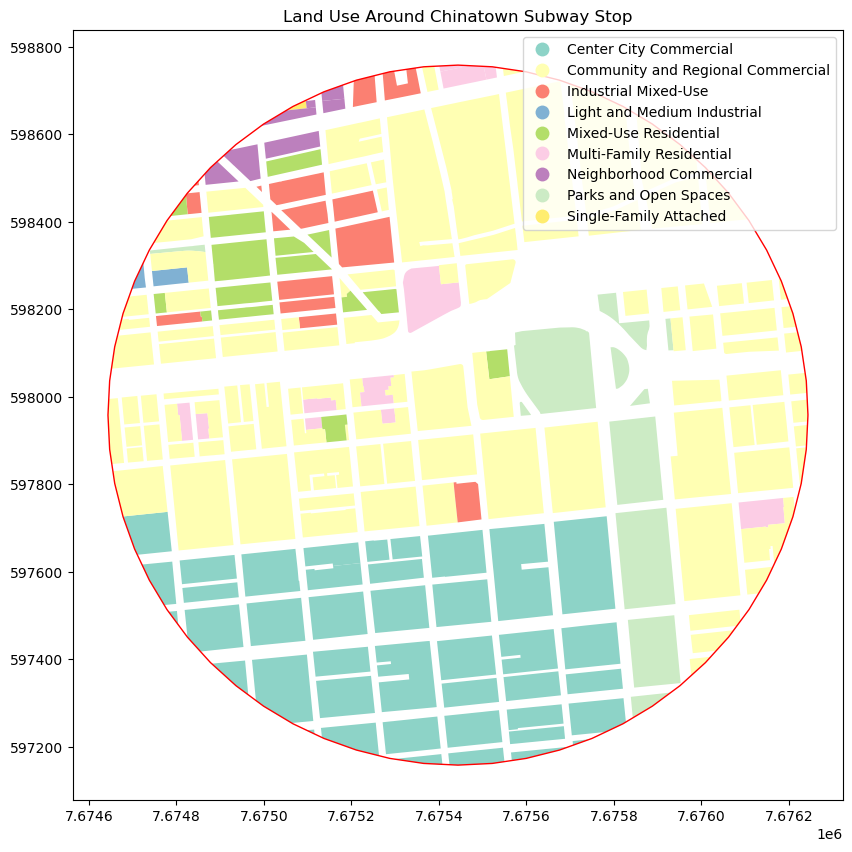

In [17]:
# Plotting an example station buffer with zoning data
station_id = "Chinatown"
station_area = zoning_near_stations[zoning_near_stations['Station'] == station_id]

fig, ax = plt.subplots(figsize=(10, 10))
station_area.plot(ax=ax, column='Specific_Category', legend=True, cmap='Set3')
stations_buffered[stations_buffered['Station'] == station_id].plot(ax=ax, color='none', edgecolor='red')
plt.title(f'Land Use Around {station_id} Subway Stop')
plt.show()


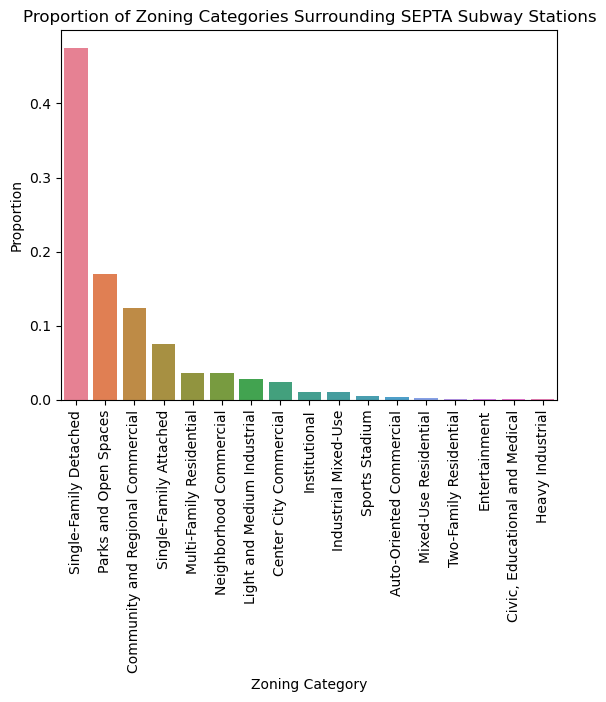

In [18]:
buffer_zones = zoning_near_stations.groupby('Specific_Category')  # Group the data by specific category
all_area = buffer_zones['Area'].sum()  # Calculate the total area for each specific category
proportion = all_area / all_area.sum()  # Calculate the proportion of each category
proportion.sort_values(ascending=False, inplace=True)  # Sort the categories by proportion in descending order

# Plotting the bar chart
sns.barplot(x=proportion.index, y=proportion.values, hue=proportion.index)
plt.ylabel('Proportion')
plt.xlabel('Zoning Category')
plt.xticks(rotation=90)
plt.xticks(proportion.index[:50])  # Set the x-axis ticks at a step of 50
plt.title('Proportion of Zoning Categories Surrounding SEPTA Subway Stations')
plt.show()

### Analysis of Zoning Categories Surrounding SEPTA Subway Stations
**Zoning Categories:** The bar chart indicates the distribution of zoning categories around SEPTA subway stations, with "Single-Family Detached" being the most prevalent. This predominance of low-density residential zoning (typically associated with suburban development) around high-capacity transit infrastructure is problematic for several reasons:

**Underutilization of Transit Infrastructure:** Subway systems are designed to serve high-density populations efficiently. Low-density zoning like "Single-Family Detached" leads to fewer residents within walking distance of transit stations, resulting in lower ridership and underutilization of the system.

**Missed Opportunities for Transit-Oriented Development (TOD):** Areas surrounding subway stations are prime locations for higher-density, mixed-use developments. Such developments can maximize the land use around stations, increase transit ridership, and reduce reliance on automobiles. The prevalence of single-family zoning may hinder these opportunities.

**Environmental Impact:** Low-density development around transit stations can contribute to urban sprawl, increased car dependency, and higher greenhouse gas emissions. Encouraging higher-density development around transit hubs can help mitigate these impacts by promoting sustainable, walkable communities.

**Zoning Reform:** Given the current zoning patterns, there may be a need for zoning reform to better align land use with the potential benefits of the existing transit infrastructure. This could involve:

**Rezoning for Higher-Density:** Introducing or expanding zoning categories that allow for multi-family residential, mixed-use, and commercial development around subway stations. This could increase the residential and commercial density, thus enhancing the efficiency of the transit system.

**Incentivizing Mixed-Use Development:** Policies could be introduced to incentivize developers to create mixed-use projects that combine residential, commercial, and office spaces. This not only increases density but also creates vibrant, walkable neighborhoods that are less reliant on cars.

**Community Engagement:** Engaging with local communities to ensure that zoning changes meet the needs of current residents while also accommodating future growth. This can help address concerns about gentrification and displacement, ensuring that transit-oriented development benefits all residents.

**Long-Term Implications:** If these zoning issues are not addressed, the region may continue to face challenges related to inefficient land use, underperforming transit systems, and unsustainable development patterns. Conversely, proactive zoning reforms could lead to a more efficient, sustainable, and vibrant urban environment.


In [19]:
# Set Census API key
census_api_key = os.getenv('CENSUS_API_KEY')
c = Census(census_api_key)

pa_blockgroup = c.acs5.state_county_blockgroup(fields = ('B01003_001E', 'B19013_001E', 'B99081_001E', 'B25077_001E', 'B25064_001E', 'B01002_001E', 'B06011_001E'),
                                      state_fips = '42',
                                      county_fips = "*",
                                      blockgroup = "*",
                                      year = 2019)

pa_blockgroup = pd.DataFrame(pa_blockgroup)

pa_tract = c.acs5.state_county_tract(fields = ('B01003_001E', 'B08201_001E'),
                                        state_fips = '42',
                                        county_fips = "*",
                                        tract = "*",
                                        year = 2019)

pa_tract = pd.DataFrame(pa_tract)

pa_tract['vehicle_density'] = pa_tract['B08201_001E'] / pa_tract['B01003_001E']
pa_tract.drop(columns = ['B01003_001E', 'B08201_001E', 'state', 'county'], inplace=True)


census_data = pa_blockgroup.merge(pa_tract, on = "tract")

# Load in the census blocks GeoDataFrame
philly_census_blocks_gdf = block_groups(state='PA', county = 'Philadelphia', year=2019)
delco_census_blocks_gdf = block_groups(state='PA', county='Delaware', year=2019)
census_blocks_gdf = pd.concat([philly_census_blocks_gdf, delco_census_blocks_gdf])
census_blocks_gdf = census_blocks_gdf.to_crs("EPSG:3347")

# Merge the census data with the census blocks GeoDataFrame
census_data['GEOID'] = census_data['state'] + census_data['county'] + census_data['tract'] + census_data['block group']
census_data = census_data.drop(columns = ['state', 'county', 'tract', 'block group'])

census_data = census_blocks_gdf.merge(census_data, on = "GEOID")


census_data.rename(columns = {
    'B01003_001E': 'population', 
    'B06011_001E': 'median_household_income', 
    'B99081_001E': 'place_of_work',
    'B01002_001E': 'median_age',
    'B25077_001E': 'median_home_value',
    'B25064_001E': 'median_gross_rent'
    }, inplace=True)

census_data = census_data[['GEOID', 'geometry', 'population', 'median_household_income', 'place_of_work', 'median_age', 'median_home_value', 'median_gross_rent', 'vehicle_density']]

Using FIPS code '42' for input 'PA'
Using FIPS code '101' for input 'Philadelphia'
Using FIPS code '42' for input 'PA'
Using FIPS code '045' for input 'Delaware'


In [32]:
pa_lodes_wac = get_lodes(
    state = "PA",
    year = 2019,
    lodes_type = "wac",
    cache = True,
)



In [33]:
pa_lodes_wac['GEOID'] = pa_lodes_wac['w_geocode'].str[:12]
pa_lodes_wac = pa_lodes_wac.drop(columns = ['w_geocode'])
pa_lodes_wac = pa_lodes_wac.groupby('GEOID').sum().reset_index()
pa_lodes_wac = pa_lodes_wac.rename(columns = {'C000': 'total_jobs', 'CA01': 'jobs_29_or_younger', 'CA02': 'jobs_30_to_54', 'CA03': 'jobs_55_or_older', })
pa_lodes_wac = pa_lodes_wac[['GEOID', 'total_jobs', 'jobs_29_or_younger', 'jobs_30_to_54', 'jobs_55_or_older']]


In [34]:
census_data = census_data.merge(pa_lodes_wac, on = "GEOID")

census_near_stations = gpd.overlay(census_data, stations_buffered, how='intersection')


MergeError: Passing 'suffixes' which cause duplicate columns {'jobs_55_or_older_x', 'total_jobs_x', 'jobs_30_to_54_x', 'jobs_29_or_younger_x'} is not allowed.

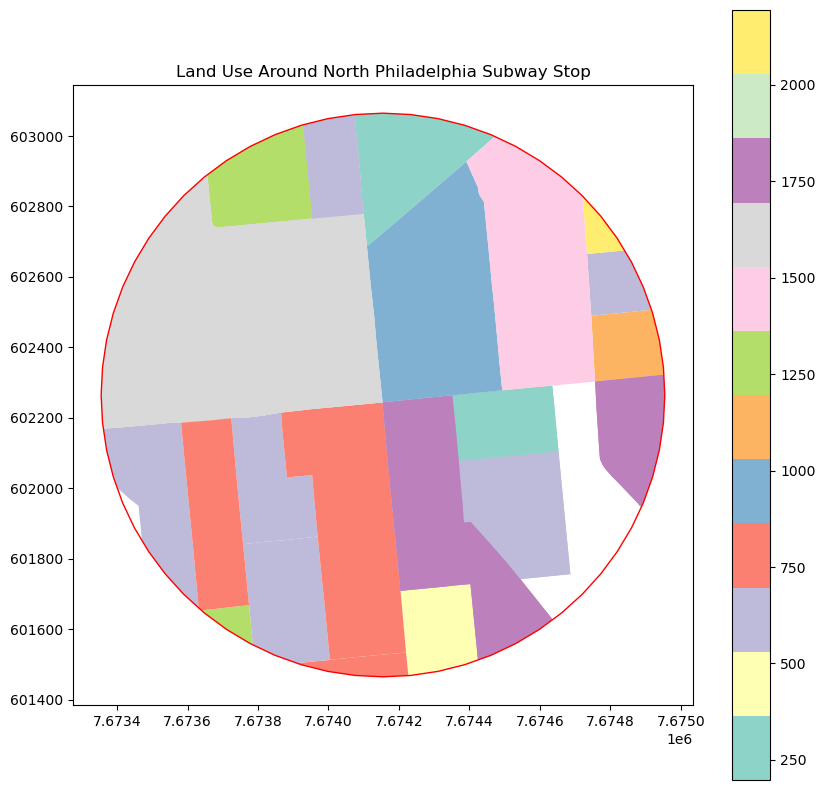

In [29]:
station_id = "North Philadelphia"
station_area = census_near_stations[census_near_stations['Station'] == station_id]


fig, ax = plt.subplots(figsize=(10, 10))
station_area.plot(ax=ax, column='population', legend=True, cmap='Set3')
stations_buffered[stations_buffered['Station'] == station_id].plot(ax=ax, color='none', edgecolor='red')
plt.title(f'Land Use Around {station_id} Subway Stop')
plt.show()


In [ ]:
station_zoning = zoning_near_stations.groupby(['Station', 'Specific_Category'])['Area'].sum().unstack(fill_value=0)
station_pop = pop_near_stations.groupby('Station')['population'].sum()


station_data = pd.merge(station_ridership, station_zoning, on='Station', how='left')
station_data = pd.merge(station_data, station_pop, on='Station', how='left')

## Model Development



In [ ]:
# Analyze potential reasons for model inaccuracy

# 1. Data preparation and feature engineering
station_zoning = zoning_near_stations.groupby(['Station', 'Specific_Category'])['Area'].sum().unstack(fill_value=0)
station_pop = pop_near_stations.groupby('Station')['population'].sum()

station_data = pd.merge(station_ridership, station_zoning, on='Station', how='left')
station_data = pd.merge(station_data, station_pop, on='Station', how='left')
# Calculate Z-scores for 'AVERAGE WEEKDAY' ridership
z_scores = np.abs((station_data['AVERAGE WEEKDAY'] - 
                   station_data['AVERAGE WEEKDAY'].mean()) / 
                   station_data['AVERAGE WEEKDAY'].std())

# Remove outliers based on Z-score threshold (e.g., 3)
outliers = station_data[z_scores >= 3]
print('There are', len(outliers), 'outliers')
print(outliers['Station'])
station_data = station_data[z_scores < 3]
# 2. Feature selection and scaling
y = station_data['AVERAGE WEEKDAY']
X = station_data.drop(['Station', 'AVERAGE WEEKDAY', 'STATION ECONOMIC PERFORMANCE'], axis=1)

# Check for multicollinearity
correlation_matrix = X.corr()
print("\nHighly correlated features:")
print(correlation_matrix[(correlation_matrix > 0.7) & (correlation_matrix < 1)].stack().drop_duplicates())

# Remove highly correlated features
X = X.drop(columns=['Auto-Oriented Commercial', 'Community and Regional Commercial', 'Parks and Open Spaces'])


Our dataset has two outliers with a z score of 3 or higher, that being City Hall and 15th Street Stations. These stations are not only outliers in terms of ridership, but also in terms of their function as transfer points for other SEPTA and NJ Transit lines. Because of this, I will remove them from the dataset as they skew the data in a way that will make it difficult to accurately predict ridership. As my model is intended to be a tool for urban planning, it is important that it is not skewed by the behavior of outlier stations.  

In [ ]:
# Model selection and evaluation
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
lm = Pipeline([('scaler', StandardScaler()), ('LR', LassoCV())])

ymean, ystd = y_train.mean(), y_train.std()
y_train_scaled = (y_train - ymean) / ystd
y_test_scaled = (y_test - ymean) / ystd

lm.fit(X_train, y_train_scaled)

print(lm.score(X_test, y_test_scaled))

y_predicted_scaled = lm.predict(X_test)
y_predicted = ymean + ystd*y_predicted_scaled

model = sm.OLS(y_train, sm.add_constant(X_train))
# OLS: "Ordinary Least Squares"
result = model.fit()
display(result.summary())
predicted = result.predict(sm.add_constant(X_test))

          
y_pred = result.predict(sm.add_constant(X_train))
plt.scatter(predicted, y_test)
plt.plot([0, 20000], [0, 20000], color='red')

In [ ]:
# Just population model
X_pop = station_data[['Population']]
X_train_pop, X_test_pop, y_train_pop, y_test_pop = train_test_split(X_pop, y, test_size=0.2, random_state=42)

model_pop = LinearRegression()
result_pop = model_pop.fit(X_train_pop, y_train_pop)
predicted_pop = result_pop.predict(X_test_pop)

print(result_pop.score(X_test_pop, y_test_pop))
plt.scatter(predicted_pop, y_test_pop)
plt.plot([0, 20000], [0, 20000], color='red')



It seems that a Random Forest would be far and away the best way to predict ridership. Let's expand on this with a grid search of hyperparameters. 

In [ ]:
# Hyperparameter tuning
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start=10, stop=110, num=5)] 
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# search across 100 different combinations, and use all available cores
rf_random = GridSearchCV(estimator = rf, param_grid = random_grid, scoring = 'r2', verbose = 2, n_jobs = -1, cv=3)
# Fit the random search model
rf_random.fit(X_train, y_train)

best_model = rf_random.best_estimator_
y_pred = best_model.predict(X_test)
mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nRandom Forest (Tuned):")
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")


### Predict ridership for boulevard extension stations
 To create an overlay of the zoning and Roosevelt Boulevard extension stations, we first buffer the boulevard extension by 800 meters to account for the area of influence around the stations. This involves copying the boulevard extension data and applying a buffer operation to its geometry. The buffered geometry is then converted into a GeoDataFrame to facilitate spatial operations. Next, we perform an intersection overlay operation between the zoning data and the buffered boulevard extension. This overlay helps identify the zoning areas that intersect with the buffered regions around the Roosevelt Boulevard extension stations, providing valuable insights into the zoning characteristics and potential impacts on the surrounding areas.



In [27]:

# Buffer the boulevard extension
boulevard_buffered = boulevard_extension.copy()
boulevard_buffered['geometry'] = boulevard_buffered.geometry.buffer(800)

# Convert the buffered GeoSeries to a GeoDataFrame
boulevard_buffered = gpd.GeoDataFrame(boulevard_buffered, geometry='geometry')

# Perform the overlay operation
zoning_near_boulevard = gpd.overlay(zoning, boulevard_buffered, how='intersection')

# Group the data by station and specific category and sum the area
boulevard_data = zoning_near_boulevard.groupby(['Station', 'Specific_Category'])['Area'].sum().unstack(fill_value=0)

# Add column for SCHEDULED TRIPS by using the average of the station_data
boulevard_data['SCHEDULED TRIPS'] = station_data['SCHEDULED TRIPS'].mean()

# Remove highly correlated features
boulevard_data = boulevard_data.drop(columns=['Auto-Oriented Commercial', 'Community and Regional Commercial', 'Parks and Open Spaces'])
# Add columns not present in boulevard_data but in X to boulevard_data
for col in X.columns:
    if col not in boulevard_data.columns:
        boulevard_data[col] = 0

# Add SCHEDULED TRIPS column to boulevard_data as the mean of X_train
boulevard_data['SCHEDULED TRIPS'] = X_train['SCHEDULED TRIPS'].mean()
# Reorder the columns of boulevard_data to match the order of X_train
boulevard_data = boulevard_data[X_train.columns]


We will now use the model to predict ridership for the Roosevelt Boulevard extension stations. The Roosevelt Boulevard extension is a line that has long been proposed in Philadelphia, but has never been built. The line would extend the Broad Street line north into Northeast Philadelphia and Bucks County, connecting Center City to an area underdeveloped by transit. My model will only predict ridership for stations within Philadelphia County, so the two stations that are in Bucks County were removed from the dataset. This is due to a lack of zoning data for the area.

In [ ]:
predictions = best_model.predict(boulevard_data)

# Add the predictions to the boulevard_data GeoDataFrame
boulevard_data['Predicted Ridership'] = predictions
total_predictions = boulevard_data['Predicted Ridership'].sum()
# Compare ridership on the new line to the existing lines

# Calculate total ridership for existing lines and add the predicted ridership for the Roosevelt Boulevard extension
ridership = pd.DataFrame({'Line': ['Broad Street Line', 'Market-Frankford Line', 'Roosevelt Boulevard Extension'], 'Ridership': [bsl_ridership['AVERAGE WEEKDAY'].sum(), mfl_ridership['AVERAGE WEEKDAY'].sum(), total_predictions]})

# Plot the comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Line', y='Ridership', data=ridership, palette='viridis')
plt.xlabel('Line')
plt.ylabel('Total Ridership')
plt.title('Comparison of Total Ridership: Existing Lines vs. Roosevelt Boulevard Extension')
plt.tight_layout()
plt.show()

# Plot the predicted ridership for the Roosevelt Boulevard extension stations
plt.figure(figsize=(10, 6))
sns.barplot(x=boulevard_data.index, y='Predicted Ridership', data=boulevard_data, palette='viridis')
plt.xlabel('Station')
plt.ylabel('Predicted Ridership')
plt.title('Predicted Ridership for Roosevelt Boulevard Extension Stations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

avg_ridership = pd.DataFrame({'Line': ['Broad Street Line', 'Market-Frankford Line', 'Roosevelt Boulevard Extension'], 'Average Ridership': [bsl_ridership['AVERAGE WEEKDAY'].sum() / len(bsl_ridership), mfl_ridership['AVERAGE WEEKDAY'].sum() / len(mfl_ridership), total_predictions / len(boulevard_data)]})

# Plot average ridership by line 
plt.figure(figsize=(10, 6))
sns.barplot(x='Line', y='Average Ridership', data=avg_ridership, palette='viridis')
plt.xlabel('Line')
plt.ylabel('Average Ridership')
plt.title('Average Ridership per Station: Existing Lines vs. Roosevelt Boulevard Extension')
plt.tight_layout()
plt.show()



## Results Analysis

